In [1]:
import pandas as pd
import pandas as pd
from process_data import DataProcessor
from neuralprophet import NeuralProphet, set_log_level
from sklearn.preprocessing import RobustScaler

# Loading the data
X_train = pd.read_csv('data/single_turbine_data/X_train.csv')
X_test = pd.read_csv('data/single_turbine_data/X_test.csv')
y_train = pd.read_csv('data/single_turbine_data/y_train.csv')
y_test = pd.read_csv('data/single_turbine_data/y_test.csv')

y_train['# Date and time'] = pd.to_datetime(y_train['# Date and time'])
y_test['# Date and time'] = pd.to_datetime(y_test['# Date and time'])

y_train.set_index('# Date and time', inplace=True)
y_test.set_index('# Date and time', inplace=True)

processor = DataProcessor(X_train)
processor.process_all()
X_train = processor.data

processor = DataProcessor(X_test)
processor.process_all()
X_test = processor.data

original_cols = ['1_Wind direction (°)',
       '1_Nacelle position (°)', '1_Power (kW)',
       '1_Front bearing temperature (°C)', '1_Rear bearing temperature (°C)',
       '1_Stator temperature 1 (°C)', '1_Nacelle ambient temperature (°C)',
       '1_Nacelle temperature (°C)', '1_Transformer temperature (°C)',
       '1_Generator bearing rear temperature (°C)',
       '1_Generator bearing front temperature (°C)', '1_Temp. top box (°C)',
       '1_Hub temperature (°C)', '1_Ambient temperature (converter) (°C)',
       '1_Rotor bearing temp (°C)', '1_Transformer cell temperature (°C)', '1_Generator RPM (RPM)']
leadsnlags = [
       '1_Wind direction (°)_lead6', 
       '1_Nacelle position (°)_lead3',
       '1_Power (kW)_lag6', 
       '1_Stator temperature 1 (°C)_lag1',
       '1_Nacelle ambient temperature (°C)_lead6',
       '1_Transformer temperature (°C)_lead6',
       '1_Generator bearing rear temperature (°C)_lag1',
       '1_Temp. top box (°C)_lag1', 
       '1_Hub temperature (°C)_lead6',
       '1_Ambient temperature (converter) (°C)_lead6',
       '1_Transformer cell temperature (°C)_lead6',
       '1_Generator RPM (RPM)_lead6']
leads = [col[:-6] for col in leadsnlags if 'lead' in col]
lags = [col[:-5] for col in leadsnlags if 'lag' in col]

extras = ['curtailed', 'offline']

cols = original_cols
X_train = X_train[cols]
X_test = X_test[cols]

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

all_data = pd.concat([train_data, test_data], axis=0)

/Users/johnny/anaconda3/envs/np/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
y_train[cols] = X_train[cols]

# promote index to column
y_train.reset_index(inplace=True)
# rename date column to ds
y_train.rename(columns={'# Date and time': 'ds', '1_Gear oil temperature (°C)': 'y'}, inplace=True)
y_train['ds'] = pd.to_datetime(y_train['ds'])

In [3]:
set_log_level("ERROR")

# Model and prediction
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=True,
    n_lags=6,
    drop_missing=True,
    # accelerator="auto",
)
m.set_plotting_backend("plotly")

# Add the new lagged regressors
for col in cols:
    if col in leads or col not in lags:
        m.add_future_regressor(col)
    else:
        m.add_lagged_regressor(col)
# Continue training the model and making a prediction
metrics = m.fit(y_train, freq="10min")
periods = len(y_test)

WARNING - (py.warnings._showwarnmsg) - /Users/johnny/anaconda3/envs/np/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

Finding best initial lr: 100%|██████████| 280/280 [00:00<00:00, 391.21it/s]


Epoch 51: 100%|██████████| 51/51 [00:02<00:00, 19.23it/s, loss=nan, v_num=9, MAE=nan.0, RMSE=nan.0, Loss=nan.0, RegLoss=0.000]    


In [7]:
import pandas as pd

data = pd.DataFrame()

for col in cols:
    concatenated_series = pd.concat([y_train[col], X_test[col].iloc[:periods]])

    data[col] = concatenated_series.reset_index(drop=True)

data['ds'] = concatenated_series.index
data['ds'] = pd.to_datetime(data['ds'])
future = m.make_future_dataframe(data, periods=periods, n_historic_predictions=180)
forecast = m.predict(future)
m.plot(forecast)

ValueError: mixed datetimes and integers in passed array

In [6]:
type(data['ds'].iloc[0])

int

In [16]:
y_train.columns

Index(['ds', 'y', '1_Wind direction (°)', '1_Nacelle position (°)',
       '1_Power (kW)', '1_Front bearing temperature (°C)',
       '1_Rear bearing temperature (°C)', '1_Stator temperature 1 (°C)',
       '1_Nacelle ambient temperature (°C)', '1_Nacelle temperature (°C)',
       '1_Transformer temperature (°C)',
       '1_Generator bearing rear temperature (°C)',
       '1_Generator bearing front temperature (°C)', '1_Temp. top box (°C)',
       '1_Hub temperature (°C)', '1_Ambient temperature (converter) (°C)',
       '1_Rotor bearing temp (°C)', '1_Transformer cell temperature (°C)',
       '1_Generator RPM (RPM)'],
      dtype='object')

In [13]:

# # Python
# import itertools
# import numpy as np
# import pandas as pd
# from prophet.diagnostics import performance_metrics
# from prophet.diagnostics import cross_validation

# param_grid = {  
#     'changepoint_prior_scale': [0.0001, 0.005, 0.001],
#     'seasonality_prior_scale': [1],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params)
#     for col in cols:
#         m.add_regressor(col)
#     m.fit(y_train)
#     df_cv = cross_validation(m, initial = '730 days', horizon='365 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [14]:
# rsme of last 300 points in fct against first 300 points in y_test

from sklearn.metrics import mean_squared_error

y_tested = y_test[:periods]
fcsted = forecast[-periods:]

mean_squared_error(y_tested['1_Gear oil temperature (°C)'], fcsted['yhat'], squared=False)

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstan

0.5577094749052838

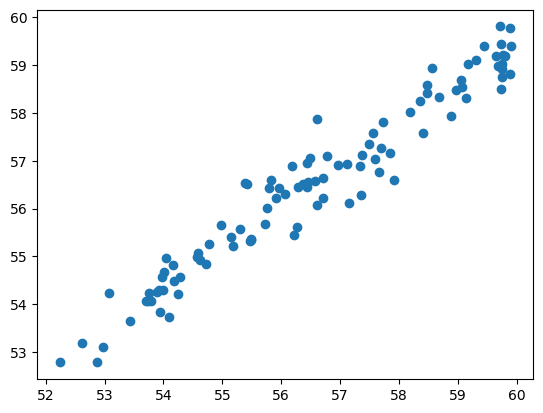

In [15]:
import matplotlib.pyplot as plt
plt.scatter(y_tested['1_Gear oil temperature (°C)'], fcsted['yhat'])

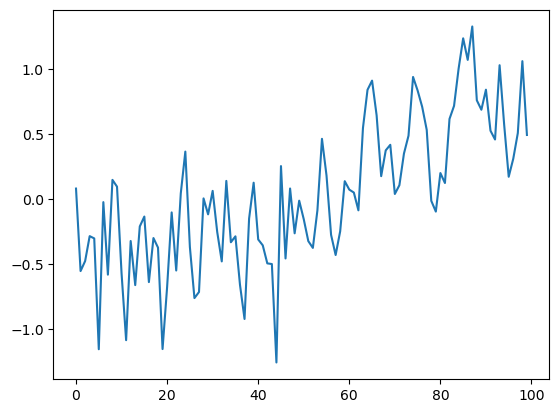

In [16]:
# plot the difference over time
plt.plot(range(len(y_tested['1_Gear oil temperature (°C)'])), y_tested['1_Gear oil temperature (°C)'].to_numpy() - fcsted['yhat'].to_numpy())

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [5]:
X_train

,1_Wind direction (°),1_Nacelle position (°),1_Power (kW),1_Front bearing temperature (°C),1_Rear bearing temperature (°C),1_Stator temperature 1 (°C),1_Nacelle ambient temperature (°C),1_Nacelle temperature (°C),1_Transformer temperature (°C),1_Generator bearing rear temperature (°C),...,1_Power (kW)_lag6,1_Stator temperature 1 (°C)_lag1,1_Nacelle ambient temperature (°C)_lead6,1_Transformer temperature (°C)_lead6,1_Generator bearing rear temperature (°C)_lag1,1_Temp. top box (°C)_lag1,1_Hub temperature (°C)_lead6,1_Ambient temperature (converter) (°C)_lead6,1_Transformer cell temperature (°C)_lead6,1_Generator RPM (RPM)_lead6
# Date and time,,,,,,,,,,,,,,,,,,,,,
2016-05-03 09:40:00,276.818054,268.365997,353.803345,72.366669,70.616669,64.250000,10.883333,20.616667,37.900002,41.533333,...,408.518976,60.570000,11.760000,37.205002,39.088000,28.057500,17.0000,15.160000,16.410000,1161.209351
2016-05-03 09:50:00,275.881958,268.365997,515.468567,73.110001,71.254997,62.160000,10.945000,19.410000,37.919998,40.544998,...,508.189194,64.250000,12.315000,37.169998,41.533333,27.733334,17.0000,15.250000,16.400000,1114.882446
2016-05-03 10:00:00,270.699310,268.365997,403.398895,69.065002,67.224998,59.150002,11.195000,19.049999,37.994999,39.044998,...,443.825671,62.160000,12.030000,36.924999,40.544998,27.340000,17.0000,15.385000,16.525000,1093.217163
2016-05-03 10:10:00,278.005402,268.365997,399.778290,70.830002,69.139999,58.740002,11.765000,23.010000,38.035000,38.634998,...,397.563135,59.150002,12.230000,36.785000,39.044998,26.620001,17.0000,15.515000,16.540001,1005.711121
2016-05-03 10:20:00,284.922363,268.365997,206.619904,68.900002,67.629997,59.174999,11.865000,24.450001,37.860001,39.119999,...,216.184726,58.740002,11.995000,36.634998,38.634998,26.209999,17.0000,15.520000,16.660000,1185.456421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-17 07:30:00,205.687649,212.305334,801.821971,71.795000,68.585001,61.255000,16.810000,25.760000,59.275000,41.520000,...,1225.562311,61.002778,15.182889,56.555110,41.213888,28.238889,21.4000,17.928000,20.607000,1502.101520
2019-06-17 07:40:00,214.209624,206.902130,1348.270200,74.840002,71.895000,64.584999,16.405000,25.082500,59.557500,42.215000,...,1347.732401,61.255000,12.361000,68.963499,41.520000,28.742500,20.2044,15.185500,18.829000,1742.674136
2019-06-17 07:50:00,204.538333,203.186624,859.228061,72.159999,68.515001,64.925000,16.375000,22.250000,60.375000,42.372500,...,610.122859,64.584999,11.358632,46.061237,42.215000,29.340000,19.8550,13.238842,16.204605,1531.947266
